In [161]:
import pandas as pd
import sqlite3
import numpy as np

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [2]:
conTXs = sqlite3.connect('./nfts-002.sqlite')

In [3]:
checkpoint = pd.read_sql_query("SELECT * FROM checkpoint", conTXs)
mints = pd.read_sql_query("SELECT * FROM mints", conTXs)
nfts = pd.read_sql_query("SELECT * FROM nfts", conTXs)
transfers = pd.read_sql_query("SELECT * FROM transfers", conTXs)

In [4]:
stolbiki = pd.read_sql_query("SELECT sql FROM sqlite_master where type='table'", conTXs) 
print(stolbiki)

                                                 sql
0  CREATE TABLE nfts\n    (\n        address TEXT...
1  CREATE TABLE checkpoint\n    (\n        event_...
2  CREATE TABLE mints\n    (\n        event_id TE...
3  CREATE TABLE transfers\n    (\n        event_i...
4  CREATE TABLE current_owners(\n  nft_address TE...
5  CREATE TABLE current_market_values(\n  nft_add...


In [5]:
# checkpoint.head(40)

In [6]:
transfers.head(4)

,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp
0,ce7b6ba0-218f-40c7-8d8c-4e3bfc822a41,0x804cee46e672b17b477658b99c25c8b75f31553278ad...,11565099,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,7287012905433418913509099434869470284131894829...,0x79A8b5Fcc051c843DFCB753eE38d113675E5367D,0x433f7e8DeFBbCB5459DDD8C6597493e41550F37f,0,1609460206
1,c81d8767-a523-410e-9f4a-21a25f8e906f,0x9b124e219f875fa0bb52d90ba937c5d8373ddc8a2c46...,11565099,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1225542446027558019364995253890488984869511709...,0x2c338BAf69A57A17E69dB86933310e92f64ab69d,0x433f7e8DeFBbCB5459DDD8C6597493e41550F37f,0,1609460206
2,d9494633-61fd-4cd6-bd42-e736e0982956,0x64a82fe7402d2efd82085a10b6a99d6fcedcac21804e...,11565044,0x6Fa769EED284a94A73C15299e1D3719B29Ae2F52,51060026,0x9503DE24f4210dA79c5e5BCCD198B2727387a519,0x8B36486EA2E0b70A505D92d30c31CC3197ba5707,0,1609459570
3,801c3aae-9b72-4a4b-b40b-1cf93308eeea,0xe74d08ee2cbe4b6b873258462ec5523999433569df66...,11565042,0xB2D6fb1Dc231F97F8cC89467B52F7C4F78484044,4265098311422702060752376543910232329671779809...,0x0BF988a6cc20af0CDD6f583aD2Fcf057895888e6,0x0000000000000000000000000000000000000000,0,1609459545


In [7]:
# transfers[transfers["transaction_value"].isnull()]


In [8]:
# transfers["transaction_value"].head(16)

In [9]:
num_df = (transfers[["transaction_value", "timestamp"]].apply(pd.to_numeric, errors='coerce'))

num_df["timestamp"] = pd.to_datetime(num_df.timestamp, unit='s', errors='coerce')
num_df.set_index("timestamp")
num_df = num_df.resample("1440min", label='right', on='timestamp').sum()


Text(0.5, 1.0, 'NFT transfers value over time')

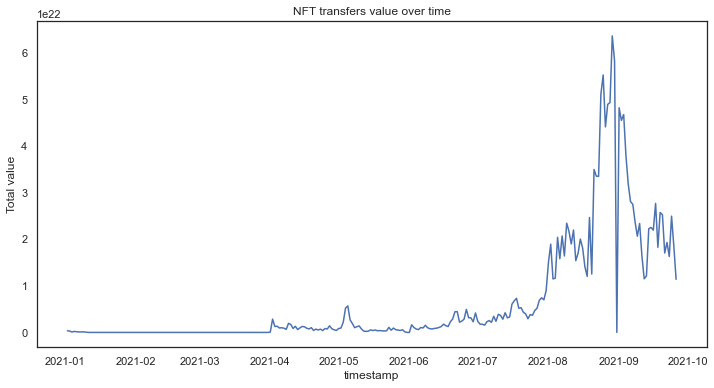

In [10]:
# Set the width and height of the figure
plt.figure(figsize=(12,6))
# Line chart showing the number of visitors to each museum over time
ax = sns.lineplot(data=num_df, x="timestamp", y="transaction_value")
ax.set(xlabel='timestamp', ylabel='Total value')
plt.title("NFT transfers value over time")
# Add title

In [11]:
print("number of unique addresses:", transfers["nft_address"].nunique())

number of unique addresses: 6749


In [12]:
# num_df = (transfers[["nft_address", "transaction_value", "timestamp"]

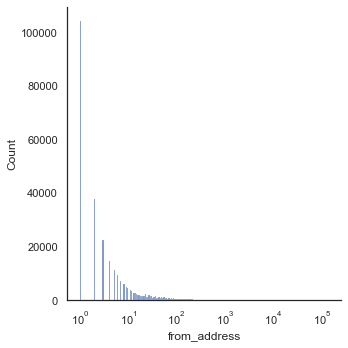

In [192]:
#create data frame where group together from_addresses and count size of each group (how many TX each address did in total)
from_series = transfers["from_address"].groupby(transfers["from_address"]).size()
ax = sns.displot(from_series, stat="count", bins=200, log_scale=True)

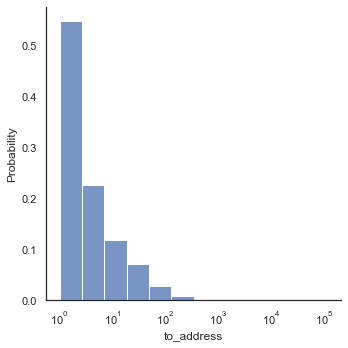

In [14]:
#create data frame where group together from_addresses and count size of each group (how many TX each address did in total)
to_series = transfers["to_address"].groupby(transfers["to_address"]).size()
#summ all same number of transactions over all addresses
# num_df =  num_df.value_counts(normalize=False, sort=True)
# to_series = num_df.rename("Number of Transactions to an address")
ax = sns.displot(to_series, stat="probability", bins=12, log_scale=True)

In [15]:
to_series

to_address
0x0000000000000000000000000000000000000000    118598
0x0000000000000000000000000000000000000001      7304
0x0000000000000000000000000000000000000069         1
0x00000000000000000000000000000000000000ff         1
0x0000000000000000000000000000000000001388         1
                                               ...  
0xfff98e0Af7Dfa591f97a768dcd71C39fA6CC7C16         2
0xfffAAD6BA8F5Cb255111EE0bB8E06e2766cb8e49        86
0xfffFa8f60d2eC6a559ef3617576ED28Bc397D360         4
0xfffaA912b2740381eB753A03E9c13c661CeFC0ed        36
0xffff0C5C628171f26B06322Db50dA0A6D1C8DD5a         3
Name: to_address, Length: 420342, dtype: int64

In [76]:
from_series.size

278519

In [107]:
df = pd.DataFrame()
df = df.join(to_series.rename("to_count"), how='outer')
df = df.join(from_series.rename('from_count'), how='outer')
# df = df.fillna(0.00001)
# from_series.to_frame().join(to_series)
df=df[df["to_count"]<10e3]
df=df[df["from_count"]<10e3]

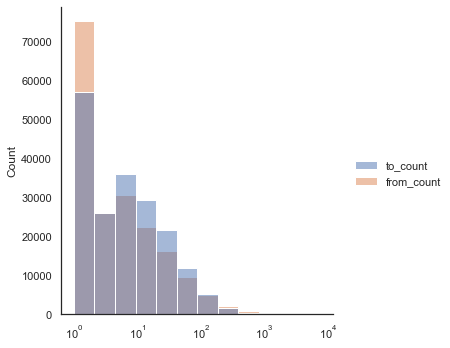

In [171]:
ax = sns.displot(df, stat="count", bins=12, log_scale=True)#multiple='dodge'

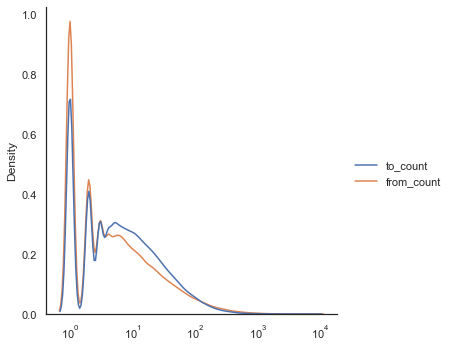

In [144]:
ax = sns.displot(df, log_scale=True, kind="kde")

In [127]:
df_small=df[df["to_count"]<10]
df_small=df_small[df_small["from_count"]<10]

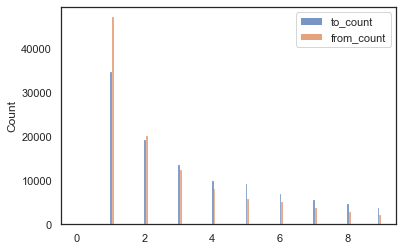

In [153]:
ax = sns.histplot(df_small, multiple="dodge")
ax.fill(True)

In [ ]:

plt.bar(df.index,df.to_count,4)

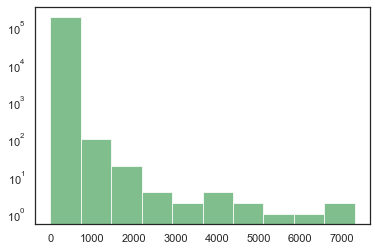

In [187]:
n, bins, patches = plt.hist(df['to_count'], density=False, facecolor='g', alpha=0.75, log=True)


In [182]:
max_value = pd.to_numeric(transfers["transaction_value"],  errors='coerce')


In [180]:
max_value["token_id"]=transfers["token_id"]
max_value.groupby(transfers["token_id"]).max()
max_value.head(4)

token_id
0      1.000000e+20
1      3.000000e+20
10     3.200000e+19
100    4.114000e+19
Name: transaction_value, dtype: float64